Big Five Personality test
- Openness to experience (inventive/curious vs. consistent/cautious): OPN
- Conscientiousness (efficient/organized vs. easy-going/careless): CSN
- Extroversion (outgoing/energetic vs. solitary/reserved): EXT
- Agreeableness (friendly/compassionate vs. challenging/detached) :AGR
- Neuroticism (sensitive/nervous vs. secure/confident): EST


Dataset: https://www.kaggle.com/datasets/tunguz/big-five-personality-test/data

Overall System Flow:
- 1. User answers questions (e.g., "I enjoy socializing with people") on a 1-5 scale
- 2. Calculate Big Five personality factors based on responses
- 3. Classify personality types using KMeans clustering
- 4. Build predictive model with Random Forest
- 5. Display results on web: "You are Type X, and this personality is suitable for Job Y"

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer


In [4]:
df_raw= pd.read_csv('data-final.csv', sep ='\t')
df_raw.head()

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  ...  \
0   4.0   1.0   5.0   2.0   5.0   1.0   5.0   2.0   4.0    1.0  ...   
1   3.0   5.0   3.0   4.0   3.0   3.0   2.0   5.0   1.0    5.0  ...   
2   2.0   3.0   4.0   4.0   3.0   2.0   1.0   3.0   2.0    5.0  ...   
3   2.0   2.0   2.0   3.0   4.0   2.0   2.0   4.0   1.0    4.0  ...   
4   3.0   3.0   3.0   3.0   5.0   3.0   3.0   5.0   3.0    4.0  ...   

              dateload  screenw  screenh  introelapse  testelapse  endelapse  \
0  2016-03-03 02:01:01    768.0   1024.0          9.0       234.0        6.0   
1  2016-03-03 02:01:20   1360.0    768.0         12.0       179.0       11.0   
2  2016-03-03 02:01:56   1366.0    768.0          3.0       186.0        7.0   
3  2016-03-03 02:02:02   1920.0   1200.0        186.0       219.0        7.0   
4  2016-03-03 02:02:57   1366.0    768.0          8.0       315.0       17.0   

   IPC  country  lat_appx_lots_of_err  long_appx_lots_of_err  
0  1.0       GB               51.5448                 0.1991  
1  1.0       MY                3.1698                101.706  
2  1.0       GB               54.9119                -1.3833  
3  1.0       GB                 51.75                  -1.25  
4  2.0       KE                   1.0                   38.0  

[5 rows x 110 columns]

In [5]:
#total count and the full list of columns names
cols = df_raw.columns.tolist()
print(f"Total columns: {len(cols)}\n")
print("All columns:")
for c in cols:
    print(c)


Total columns: 110

All columns:
EXT1
EXT2
EXT3
EXT4
EXT5
EXT6
EXT7
EXT8
EXT9
EXT10
EST1
EST2
EST3
EST4
EST5
EST6
EST7
EST8
EST9
EST10
AGR1
AGR2
AGR3
AGR4
AGR5
AGR6
AGR7
AGR8
AGR9
AGR10
CSN1
CSN2
CSN3
CSN4
CSN5
CSN6
CSN7
CSN8
CSN9
CSN10
OPN1
OPN2
OPN3
OPN4
OPN5
OPN6
OPN7
OPN8
OPN9
OPN10
EXT1_E
EXT2_E
EXT3_E
EXT4_E
EXT5_E
EXT6_E
EXT7_E
EXT8_E
EXT9_E
EXT10_E
EST1_E
EST2_E
EST3_E
EST4_E
EST5_E
EST6_E
EST7_E
EST8_E
EST9_E
EST10_E
AGR1_E
AGR2_E
AGR3_E
AGR4_E
AGR5_E
AGR6_E
AGR7_E
AGR8_E
AGR9_E
AGR10_E
CSN1_E
CSN2_E
CSN3_E
CSN4_E
CSN5_E
CSN6_E
CSN7_E
CSN8_E
CSN9_E
CSN10_E
OPN1_E
OPN2_E
OPN3_E
OPN4_E
OPN5_E
OPN6_E
OPN7_E
OPN8_E
OPN9_E
OPN10_E
dateload
screenw
screenh
introelapse
testelapse
endelapse
IPC
country
lat_appx_lots_of_err
long_appx_lots_of_err


In [6]:
cols_to_drop = [
    "dateload", "screenw", "screenh", "introelapse", "testelapse",
    "endelapse", "IPC", "country", "lat_appx_lots_of_err", "long_appx_lots_of_err"
]
df_clean = df_raw.drop(columns=[c for c in cols_to_drop if c in df_raw.columns], errors="ignore")

# Convert to numeric (in case of string entries)
df_clean = df_clean.apply(pd.to_numeric, errors="coerce")

# Replace out-of-range values (<1 or >5) with NaN
df_clean = df_clean.where((df_clean >= 1) & (df_clean <= 5))

# Drop rows that are entirely NaN for all Big Five columns (optional but safe)
df_clean = df_clean.dropna(how='all')

# Check if missing values remain
print("Total null values:", df_clean.isnull().sum().sum())
print("Remaining rows:", len(df_clean))

Total null values: 48270985
Remaining rows: 960356


In [7]:
def pick_prefix(columns, prefix):
    """Return columns like EXT1..EXT10 that match a given prefix."""
    rx = re.compile(rf"^{re.escape(prefix)}\d+$")
    return [c for c in columns if rx.match(c)]

ext_cols = pick_prefix(cols, "EXT")  # Extraversion
est_cols = pick_prefix(cols, "EST")  # Emotional Stability
agr_cols = pick_prefix(cols, "AGR")  # Agreeableness
csn_cols = pick_prefix(cols, "CSN")  # Conscientiousness
opn_cols = pick_prefix(cols, "OPN")  # Openness

ocean_items = ext_cols + est_cols + agr_cols + csn_cols + opn_cols
meta_cols = [c for c in cols if c not in ocean_items]

print("\n--- Big Five item columns per trait ---")
print(f"EXT: {len(ext_cols)}, {ext_cols}")
print(f"EST: {len(est_cols)}, {est_cols}")
print(f"AGR: {len(agr_cols)}, {agr_cols}")
print(f"CSN: {len(csn_cols)}, {csn_cols}")
print(f"OPN: {len(opn_cols)},{opn_cols}")

# print(f"\n total item columns: {len(ocean_items)}")


--- Big Five item columns per trait ---
EXT: 10, ['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10']
EST: 10, ['EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10']
AGR: 10, ['AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10']
CSN: 10, ['CSN1', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10']
OPN: 10,['OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10']


In [8]:
# Check for null values

# 1) Count total null values across the whole dataset
total_nulls = df_raw.isnull().sum().sum()
print(f"Total number of null (missing) values: {total_nulls:,}")

# handling missing value
rows_null = df_raw.isnull().any(axis=1).sum()
print(f"Rows containing at least one null value: {rows_null:,}")


Total number of null (missing) values: 186,435
Rows containing at least one null value: 3,289


In [9]:
# change every column to be numeric
# df_raw = df_raw.apply(pd.to_numeric, errors="coerce")

# df_clean = df_raw.dropna()


total_missing = df_clean.isnull().sum().sum()
print(f"Remaining rows after removing nulls: {len(df_clean):,}")
print(f"Remaining columns: {len(df_clean.columns)}")
print(f"Total missing values left: {total_missing}")

Remaining rows after removing nulls: 960,356
Remaining columns: 100
Total missing values left: 48270985


In [10]:
# column picking helpers

def pick_prefix(columns, prefix):
    """Return columns like EXT1..EXT10 strictly (prefix + digits)."""
    rx = re.compile(rf"^{re.escape(prefix)}\d+$")
    return [c for c in columns if rx.match(c)]

ext = pick_prefix(df_clean.columns, "EXT")  # Extraversion items
est = pick_prefix(df_clean.columns, "EST")  # Emotional Stability (inverse of N)
agr = pick_prefix(df_clean.columns, "AGR")  # Agreeableness items
csn = pick_prefix(df_clean.columns, "CSN")  # Conscientiousness items
opn = pick_prefix(df_clean.columns, "OPN")  # Openness items

# Sanity check: 10 items per trait in the standard 50-item inventory
assert len(ext)==len(est)==len(agr)==len(csn)==len(opn)==10, "Each trait should have 10 items."

item_cols = ext + est + agr + csn + opn

In [11]:
#Compute O, C, E, A, N on the native 1-5 scle

O = df_clean[opn].mean(axis=1)
C = df_clean[csn].mean(axis=1)
E = df_clean[ext].mean(axis=1)
A = df_clean[agr].mean(axis=1)
N = 6.0 - df_clean[est].mean(axis=1)
#N = (max + min) - EST, because N is opposite of est value

df_ocean = pd.DataFrame({"O": O, "C": C, "E": E, "A": A, "N": N}).astype(float)

# Quick personality print, average of Big Five features by ppl
print("OCEAN head (1-5):")
print(df_ocean.head())

OCEAN head (1-5):
     O    C    E    A    N
0  3.3  3.2  3.0  3.1  3.6
1  2.7  3.1  3.4  3.2  3.9
2  3.1  2.8  2.9  2.8  3.4
3  3.1  2.7  2.6  3.2  3.3
4  3.6  3.2  3.5  3.0  3.7


In [12]:
# Summary stats

summary_stats = df_ocean.describe().T
print("\nOCEAN summary statistics (1-5 scale):")
print(summary_stats.round(3))


OCEAN summary statistics (1-5 scale):
      count   mean    std  min  25%  50%    75%  max
O  959816.0  3.291  0.380  1.0  3.0  3.3  3.556  5.0
C  959885.0  3.147  0.386  1.0  2.9  3.1  3.400  5.0
E  960165.0  3.044  0.345  1.0  2.8  3.0  3.200  5.0
A  959966.0  3.178  0.357  1.0  3.0  3.2  3.400  5.0
N  959819.0  2.953  0.652  1.0  2.5  3.0  3.400  5.0


In [40]:
#<example of visualization of OCEAN result by user>
def draw_ocean_radar(ocean_scores, title="Your Big Five Personality Profile"):

    # Expecting ocean_scores to be like: {"O":3.2, "C":3.8, "E":2.9, "A":3.4, "N":3.1}

    # Define the Big Five traits in order
    traits = ["O", "C", "E", "A", "N"]

    # Extract their values and repeat the first one to close the shape
    values = [ocean_scores[t] for t in traits]
    values += values[:1]

    # Set the angles for each axis (5 traits evenly spaced on a circle)
    angles = np.linspace(0, 2 * np.pi, len(traits), endpoint=False).tolist()
    angles += angles[:1]  # repeat the first angle to close the circle

    # Create the radar chart
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color="blue", linewidth=2, linestyle="-", marker="o")
    ax.fill(angles, values, color="skyblue", alpha=0.3)

    # Add labels and style
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits, fontsize=12, fontweight="bold")
    ax.set_ylim(1, 5)
    ax.set_yticks([1,2,3,4,5])
    ax.set_yticklabels(["1","2","3","4","5"], color="gray", size=9)

    ax.set_title(title, size=14, weight="bold", pad=20)
    plt.tight_layout()
    plt.show()



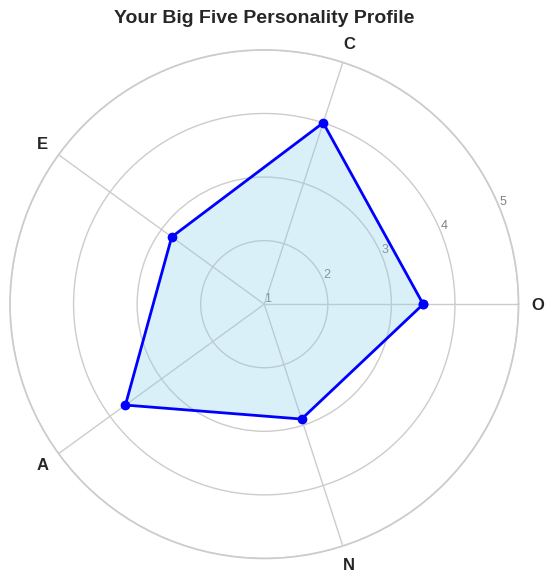

In [42]:
my_ocean = {"O":3.5, "C":4.0, "E":2.8, "A":3.7, "N":2.9}
draw_ocean_radar(my_ocean)

In [43]:
# Natural-language summary generator (short, editable rules), example of result of natural language

def summarize_ocean(ocean_series):
    """
    Turn a single OCEAN Series (1..5 each) into a short natural-language summary.
    Thresholds are simple heuristics; tailor them to your audience.
    """
    def level(x):
        if x >= 4.0: return "high"
        if x >= 3.0: return "moderate"
        return "low"

    o, c, e, a, n = (ocean_series[k] for k in ["O","C","E","A","N"])
    lines = [
        f"Openness: {o:.2f} ({level(o)}) — curiosity, creativity, and abstract thinking.",
        f"Conscientiousness: {c:.2f} ({level(c)}) — organization, reliability, and goal focus.",
        f"Extraversion: {e:.2f} ({level(e)}) — social energy, assertiveness, and talkativeness.",
        f"Agreeableness: {a:.2f} ({level(a)}) — empathy, cooperation, and trust.",
        f"Neuroticism: {n:.2f} ({level(n)}) — emotional sensitivity and stress reactivity.",
    ]
    # A compact headline based on top-2 traits
    top2 = list(ocean_series.sort_values(ascending=False).index[:2])
    headline = "Dominant traits: " + ", ".join(top2)
    return headline + "\n" + "\n".join(lines)

# Example: a natural-language summary for the population mean
print("\n Population OCEAN summary")
print(summarize_ocean(df_ocean.mean()))



=== Population OCEAN summary ===
Dominant traits: O, A
Openness: 3.29 (moderate) — curiosity, creativity, and abstract thinking.
Conscientiousness: 3.15 (moderate) — organization, reliability, and goal focus.
Extraversion: 3.04 (moderate) — social energy, assertiveness, and talkativeness.
Agreeableness: 3.18 (moderate) — empathy, cooperation, and trust.
Neuroticism: 2.95 (low) — emotional sensitivity and stress reactivity.


In [16]:
# df_ocean file save
df_ocean.to_csv('df_ocean.csv', index=False)

In [17]:
df_ocean_clean = df_ocean.dropna()  # remove any rows with NaN
print(f"Rows before: {len(df_ocean)}, after removing NaN: {len(df_ocean_clean)}")


Rows before: 960356, after removing NaN: 959618


In [18]:
# Prepare the OCEAN data
cols = ["O", "C", "E", "A", "N"]
df_temp = df_ocean[cols].copy()


In [19]:
#Handle missing values with KNN imputation (keep all rows)
imputer = KNNImputer(n_neighbors=5, weights="distance")
X_imputed = imputer.fit_transform(df_temp)


In [20]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


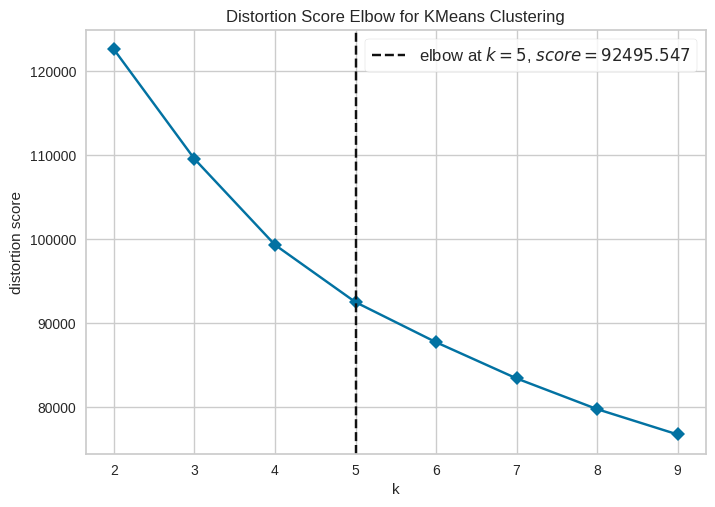

Best k (Elbow): 5


In [21]:

from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(random_state=42, n_init=10)
viz_elb = KElbowVisualizer(kmeans, k=(2, 10), timings=False)


rng = np.random.default_rng(42)
idx = rng.choice(len(X_scaled), size=min(30_000, len(X_scaled)), replace=False)
X_elb = X_scaled[idx].astype("float32", copy=False)

viz_elb.fit(X_elb)
viz_elb.show()

best_k = viz_elb.elbow_value_
print("Best k (Elbow):", best_k)


[Cluster center on 1–5 scale]
            O     C     E     A     N
Cluster                              
0        3.50  3.26  2.76  3.06  2.64
1        2.96  3.05  3.09  3.28  2.58
2        3.54  3.53  3.33  3.52  2.44
3        3.42  3.13  3.19  3.22  3.57
4        3.01  2.80  2.88  2.83  3.38

Explained variance ratio by PCA: [33.25 20.2 ]%


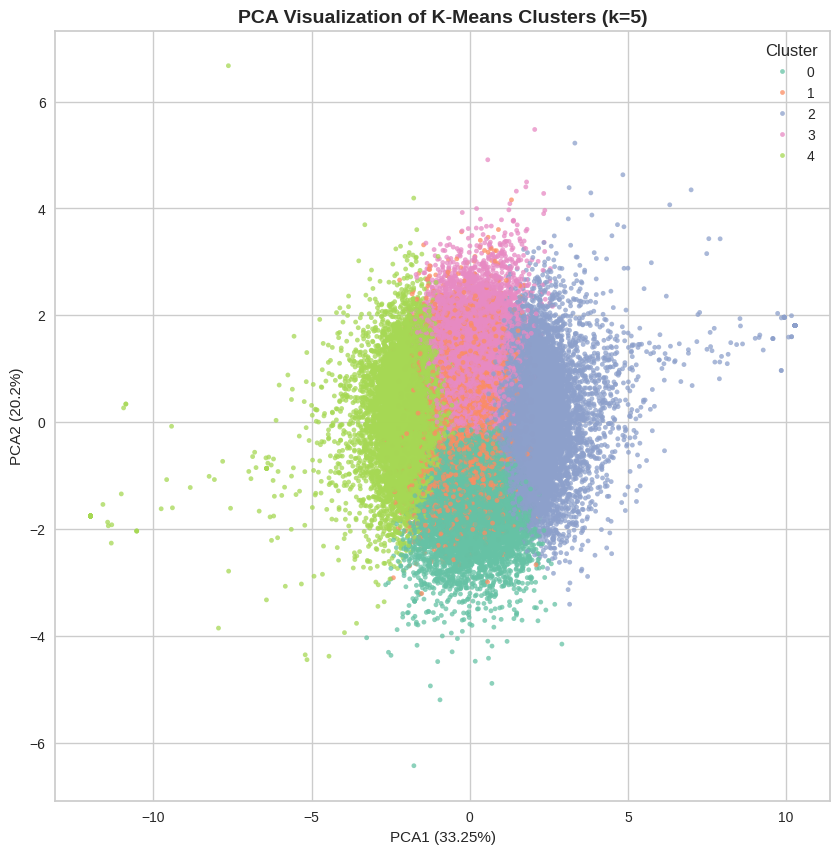

In [44]:
# PCA Visualization for K-Means (k=5) I commented out for GPU size

import seaborn as sns
from sklearn.decomposition import PCA

RANDOM_SEED = 42


kmeans_5 = KMeans(n_clusters=5, random_state=RANDOM_SEED, n_init=10)
labels_5 = kmeans_5.fit_predict(X_scaled)

# attach label on cluster
df_ocean_k5 = df_ocean.copy()
df_ocean_k5["cluster"] = labels_5

# calculate cluster center
centers_scaled = kmeans_5.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=["O","C","E","A","N"]).round(2)
centers_df.index.name = "Cluster"

print("\n[Cluster center on 1–5 scale]")
print(centers_df)

# PCA for dimensionality reduction (2 components)
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)
explained = np.round(pca.explained_variance_ratio_ * 100, 2)
print(f"\nExplained variance ratio by PCA: {explained}%")

# Combine PCA and clusters
df_pca = pd.DataFrame(X_pca, columns=["PCA1","PCA2"])
df_pca["Cluster"] = labels_5

# sample
rng = np.random.default_rng(RANDOM_SEED)
plot_idx = rng.choice(len(df_pca), size=min(100_000, len(df_pca)), replace=False)
df_plot = df_pca.iloc[plot_idx]


plt.figure(figsize=(10,10))
sns.scatterplot(
    data=df_plot,
    x="PCA1", y="PCA2",
    hue="Cluster",
    palette="Set2",
    alpha=0.75,
    s=12,
    linewidth=0
)
plt.title("PCA Visualization of K-Means Clusters (k=5)", fontsize=14, weight="bold")
plt.xlabel(f"PCA1 ({explained[0]}%)")
plt.ylabel(f"PCA2 ({explained[1]}%)")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.show()


In [45]:
# Interactive 3D PCA scatter , I commented out for GPU size
import plotly.express as px

rng = np.random.default_rng(42)
plot_idx = rng.choice(len(X_scaled), size=min(80_000, len(X_scaled)), replace=False)

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)
expl = np.round(pca3.explained_variance_ratio_ * 100, 2)

df_plot = pd.DataFrame({
    "PCA1": X_pca3[plot_idx, 0],
    "PCA2": X_pca3[plot_idx, 1],
    "PCA3": X_pca3[plot_idx, 2],
    "Cluster": labels_5[plot_idx].astype(int)
})

fig = px.scatter_3d(
    df_plot, x="PCA1", y="PCA2", z="PCA3",
    color="Cluster", opacity=0.7
)
fig.update_traces(marker=dict(size=2))
fig.update_layout(
    title=f"PCA 3D (k=5) — Explained variance: PC1 {expl[0]}%, PC2 {expl[1]}%, PC3 {expl[2]}%",
    scene = dict(
        xaxis_title=f"PCA1 ({expl[0]}%)",
        yaxis_title=f"PCA2 ({expl[1]}%)",
        zaxis_title=f"PCA3 ({expl[2]}%)"
    )
)
fig.show()


Random Forest classifier to predict KMeans (by user input)

In [24]:
# Start Random Forest classifier to predict KMeans(k=5), from OCEAN features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


In [25]:
# prepare data
# X: scaled OCEAN features (same as used for K-Means)
# y: cluster labels from K-Means (k=5)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_5 = kmeans_5.fit_predict(X_scaled)

X = X_scaled.astype("float32", copy=False)
y = np.asarray(labels_5, dtype=int)

In [26]:
# train and test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
# train randomforest
# - n_estimators: higher → more stable, slower. 200~500 reasonable.
# - class_weight='balanced' in case of mild imbalance.
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_tr, y_tr)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [28]:
# Evaluate
y_pred = rf.predict(X_te)
print(f"Accuracy: {accuracy_score(y_te, y_pred):.4f}\n")
print("Classification report:\n", classification_report(y_te, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))


Accuracy: 0.9862

Classification report:
               precision    recall  f1-score   support

           0      0.988     0.989     0.988     42157
           1      0.985     0.989     0.987     39774
           2      0.991     0.980     0.986     29755
           3      0.985     0.988     0.987     47307
           4      0.983     0.983     0.983     33079

    accuracy                          0.986    192072
   macro avg      0.986     0.986     0.986    192072
weighted avg      0.986     0.986     0.986    192072

Confusion matrix:
 [[41684    80    40   170   183]
 [   85 39317   106    98   168]
 [  125   199 29169   262     0]
 [  105   113   118 46746   225]
 [  204   189     0   180 32506]]


In [29]:
# Cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(rf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
# print(f"CV accuracy (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [30]:
# Feature importance
feat_names = ["O","C","E","A","N"]
importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nFeature importances:\n", importances)


Feature importances:
 N    0.231876
O    0.207192
A    0.194632
E    0.190434
C    0.175865
dtype: float64


In [31]:
# Persist models (so web service can load and predict)
joblib.dump(rf, "rf_cluster_k5.joblib")
joblib.dump(scaler, "ocean_scaler.joblib")
joblib.dump(kmeans_5, "kmeans_k5.joblib")



['kmeans_k5.joblib']

In [34]:
import pickle

with open("rf_model_k5.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("kmeans_model_k5.pkl", "wb") as f:
    pickle.dump(kmeans_5, f)

with open("scaler_k5.pkl", "wb") as f:
    pickle.dump(scaler, f)

predicted cluster: 3
cluster probability: [0.01  0.003 0.41  0.577 0.   ]
Your personality type: The Empathetic Mediator
You are an empathetic, cooperative coordinator in terms of personality profile.


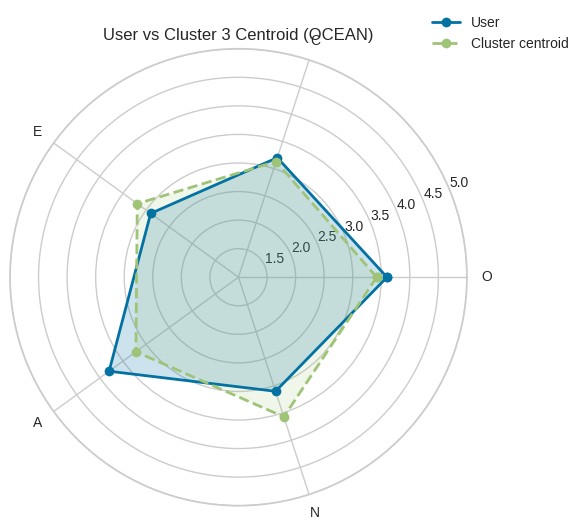

In [46]:
# Example
# 1) Input validator: ensure O,C,E,A,N in [1,5]

def validate_ocean(o, c, e, a, n):
    """Raise ValueError if any value is out of [1,5]."""
    vals = [o, c, e, a, n]
    for v in vals:
        fv = float(v)
        if not (1.0 <= fv <= 5.0):
            raise ValueError("All O,C,E,A,N scores must be in [1,5].")


# 2) Predict cluster and probabilities with RF

def predict_cluster_from_ocean(o, c, e, a, n, scaler_obj, rf_model):
    """
    Predict KMeans(k=5) cluster label using trained RandomForest.
    Inputs are O,C,E,A,N on 1..5 scale.
    Returns: (pred_label:int, proba: np.ndarray of shape (5,))
    """
    validate_ocean(o, c, e, a, n)
    x = np.array([[o, c, e, a, n]], dtype="float32")
    x_scaled = scaler_obj.transform(x)
    pred = int(rf_model.predict(x_scaled)[0])
    proba = rf_model.predict_proba(x_scaled)[0]
    return pred, proba


# 3) cluster description
cluster_desc_en = {
    0: "a sociable, upbeat team player",
    1: "a responsible, systematic planner",
    2: "an analytical, calm thinker",
    3: "an empathetic, cooperative coordinator",
    4: "a creative, curious explorer"
}


# 4) radar chart (user vs cluster centroid)

def get_centers_df_if_available(scaler_obj=None, kmeans_model=None,
                                df_ocean=None, labels=None):
    """Return centers_df (k x 5 with ['O','C','E','A','N']) if possible; else None."""
    cols = ["O","C","E","A","N"]
    # (a) centers_df global
    if 'centers_df' in globals():
        cdf = globals()['centers_df']
        if isinstance(cdf, pd.DataFrame) and all(c in cdf.columns for c in cols):
            return cdf.copy()

    # (b) from kmeans centers (scaled) + scaler
    if kmeans_model is not None and scaler_obj is not None:
        try:
            centers_scaled = kmeans_model.cluster_centers_
            centers_orig = scaler_obj.inverse_transform(centers_scaled)
            return pd.DataFrame(centers_orig, columns=cols)
        except Exception:
            pass

    # (c) group mean from df_ocean + labels
    if (df_ocean is not None) and (labels is not None):
        try:
            tmp = df_ocean.copy()
            tmp["cluster"] = np.asarray(labels, dtype=int)
            return tmp.groupby("cluster")[cols].mean()
        except Exception:
            pass

    return None

def plot_radar_user_vs_centroid(user_ocean_dict, centroid_series, title="User vs Cluster Centroid (OCEAN)"):
    """Simple radar plot using matplotlib (no custom styles)."""
    traits = ["O","C","E","A","N"]
    user_vals = [float(user_ocean_dict[t]) for t in traits]
    cent_vals = [float(centroid_series[t]) for t in traits]

    # close loops
    user_vals += user_vals[:1]
    cent_vals += cent_vals[:1]

    angles = [n/float(len(traits))*2.0*np.pi for n in range(len(traits))]
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, user_vals, marker="o", linewidth=2, label="User")
    ax.fill(angles, user_vals, alpha=0.2)
    ax.plot(angles, cent_vals, marker="o", linewidth=2, linestyle="--", label="Cluster centroid")
    ax.fill(angles, cent_vals, alpha=0.15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits)
    ax.set_ylim(1.0, 5.0)
    ax.set_title(title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
    plt.tight_layout()
    plt.show()


# 5) predict + print + visualization radar

cluster_names = {
    0: "The Social Explorer",
    1: "The Organizer",
    2: "The Calm Analyst",
    3: "The Empathetic Mediator",
    4: "The Creative Thinker"
}

def run_ocean_test(o, c, e, a, n,
                   scaler_obj, rf_model,
                   kmeans_model=None, df_ocean=None, labels=None,
                   plot=True):
    """
    End-to-end test:
    1) Predict cluster from OCEAN (1-5)
    2) Print cluster description
    3) If centroids are available, draw user vs centroid radar
    """
    pred, proba = predict_cluster_from_ocean(o, c, e, a, n, scaler_obj, rf_model)
    cluster_name = cluster_names.get(pred, f"Cluster {pred}")

    # Print result
    print(f"predicted cluster: {pred}")
    print(f"cluster probability: {np.round(proba, 3)}")
    print(f"Your personality type: {cluster_name}")
    print(f"You are {cluster_desc_en.get(pred, f'Cluster {pred}')} in terms of personality profile.")

    # Optional visualization
    if plot:
        centers = get_centers_df_if_available(scaler_obj=scaler_obj,
                                              kmeans_model=kmeans_model,
                                              df_ocean=df_ocean,
                                              labels=labels)
        if centers is not None and pred in centers.index:
            user_ocean = {"O":o, "C":c, "E":e, "A":a, "N":n}
            centroid = centers.loc[pred]
            plot_radar_user_vs_centroid(user_ocean, centroid,
                                        title=f"User vs Cluster {pred} Centroid (OCEAN)")
        else:
            print("no information of cluster centroid")


# 6) Example run

run_ocean_test(
    o=3.6, c=3.2, e=2.9, a=3.8, n=3.1,
    scaler_obj=scaler, rf_model=rf,
    kmeans_model=globals().get('kmeans_5', None),
    df_ocean=globals().get('df_ocean', None),
    labels=globals().get('labels_5', None),
    plot=True
)
